In [1]:
%%html
<style> table {margin-left: 0 !important;} </style>

In [2]:
import sys
! hostname
! whoami
print(sys.executable)
print(sys.version)
print(sys.version_info)

ip-172-26-5-168


sensei


/opt/jupyterhub/bin/python3
3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [3]:
# =====================================================================
# Script: plot_contours_gridded_from_xyz.py
# Author(s): Sensei + OpenAI
# Date: 2025-08-12
# Description:
#   Plan-view contouring from scattered XYZ by gridding + interpolation.
#   Supports line or filled contours, optional basemap, and overlay of
#   original points. Designed for JupyterBook lessons.
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_contours_gridded_from_xyz(
    filename,
    sep='\t',
    # levels: pass explicit list, or define start/stop/step, or None to auto
    levels=None,
    level_start=None, level_stop=None, level_step=None,
    nx=200, ny=200,
    method='cubic',                # 'linear'|'cubic'|'nearest'
    fillna='nearest',              # None|'nearest'
    filled=False,                  # False: contour lines; True: filled
    cmap='terrain',
    show_points=True,
    point_size=6, point_color='k',
    basemap_path=None,             # e.g., "SomewhereUSABaseMap.png"
    basemap_extent=None,           # (xmin, xmax, ymin, ymax) if using basemap
    title=None,
    ax=None
):
    """
    Plot plan-view contours by first interpolating scattered XYZ onto a grid.

    Parameters
    ----------
    filename : str
        Path to text file with columns 'X-Easting', 'Y-Northing', 'Z-Elevation'.
    sep : str, optional
        Column delimiter (default tab).
    levels : sequence of float, optional
        Explicit contour levels. If None, will use (level_start, level_stop, level_step)
        if provided, else auto-generate 10 levels from data range.
    level_start, level_stop, level_step : float, optional
        Convenience to build levels = np.arange(start, stop+step, step).
    nx, ny : int
        Grid resolution in X and Y.
    method : {'linear','cubic','nearest'}
        griddata interpolation method.
    fillna : {None,'nearest'}
        Fill NaNs after interpolation (useful near convex hull edges).
    filled : bool
        If True, use filled contours (contourf); else contour lines.
    cmap : str
        Matplotlib colormap for filled contours.
    show_points : bool
        Overlay original survey points.
    point_size : float
        Marker size for original points.
    point_color : str
        Color for original points.
    basemap_path : str or None
        Optional raster image path to show under contours.
    basemap_extent : tuple or None
        Extent (xmin, xmax, ymin, ymax) for basemap.
    title : str or None
        Plot title; defaults to 'Contour Plot from <filename>'.
    ax : matplotlib Axes or None
        Axes to draw into. If None, a new figure/axes is created.

    Returns
    -------
    Xg, Yg, Zg, cs, ax : ndarray, ndarray, ndarray, QuadContourSet, Axes
        Gridded coordinates/values, the contour set, and the axes.

    Provenance
    ----------
    Script by Sensei + OpenAI (2025-08-12)
    """
    # --- Load data ---
    df = pd.read_csv(filename, sep=sep)
    x = df['X-Easting'].to_numpy()
    y = df['Y-Northing'].to_numpy()
    z = df['Z-Elevation'].to_numpy()
    xy = np.column_stack([x, y])

    # --- Build grid ---
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    Xg, Yg = np.meshgrid(xi, yi)

    # --- Interpolate to grid ---
    Zg = griddata(xy, z, (Xg, Yg), method=method)
    if fillna == 'nearest':
        mask = np.isnan(Zg)
        if mask.any():
            Zg[mask] = griddata(xy, z, (Xg, Yg), method='nearest')[mask]

    # --- Levels logic ---
    if levels is None:
        if (level_start is not None) and (level_stop is not None) and (level_step is not None):
            levels = np.arange(level_start, level_stop + 0.5 * level_step, level_step, dtype=float)
        else:
            zmin = np.nanmin(Zg); zmax = np.nanmax(Zg)
            levels = np.linspace(zmin, zmax, 10)

    # --- Plot ---
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 6.5))
        created_fig = True
    else:
        fig = ax.get_figure()

    # Optional basemap
    if basemap_path is not None:
        im = plt.imread(basemap_path)
        if basemap_extent is None:
            basemap_extent = (x.min(), x.max(), y.min(), y.max())
        ax.imshow(im, extent=basemap_extent, origin='upper')

    # Contours
    if filled:
        cs = ax.contourf(Xg, Yg, Zg, levels=levels, cmap=cmap)
        cb = fig.colorbar(cs, ax=ax, shrink=0.85, pad=0.02)
        cb.set_label('Z')
    else:
        cs = ax.contour(Xg, Yg, Zg, levels=levels, linewidths=1.25, colors='k')
        ax.clabel(cs, inline=True, fontsize=10)

    if show_points:
        ax.scatter(x, y, s=point_size, c=point_color, label='Survey Points')
        ax.legend(loc='lower right')

    ax.set_title(title or f'Contour Plot from {filename}')
    ax.set_xlabel('X Coordinate (Easting)')
    ax.set_ylabel('Y Coordinate (Northing)')
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)

    if created_fig:
        plt.tight_layout()
        plt.show()

    return Xg, Yg, Zg, cs, ax


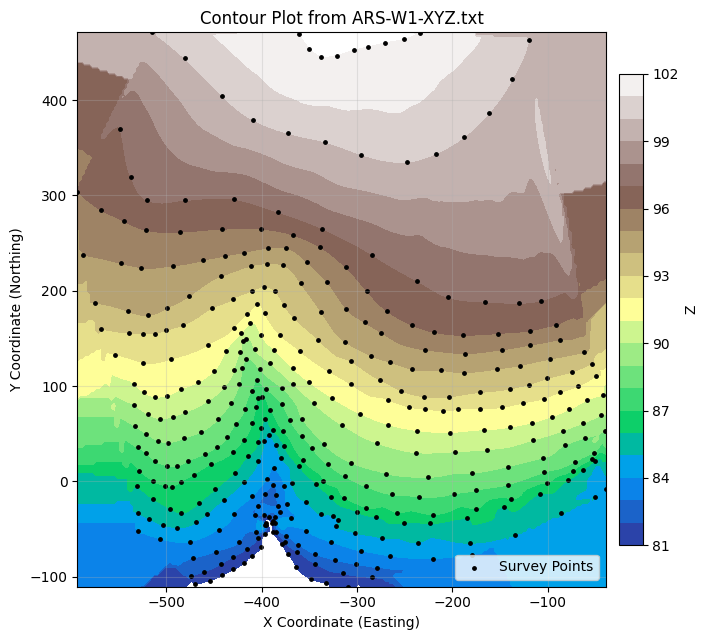

In [4]:
# Gridded, filled contours with explicit levels
Xg, Yg, Zg, cs, ax = plot_contours_gridded_from_xyz(
    'ARS-W1-XYZ.txt',
    filled=True, cmap='terrain',
    level_start=81, level_stop=102, level_step=1,
    show_points=True
)

In [5]:
# =====================================================================
# Script: plot_contours_triangulated_from_xyz.py
# Author(s): Sensei + OpenAI
# Date: 2025-08-12
# Description:
#   Plan-view contouring from scattered XYZ using Delaunay triangulation,
#   with safe interpolation at arbitrary (x,y) query points. Outside-hull
#   behavior is configurable (nan or nearest-neighbor fallback).
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.tri import LinearTriInterpolator
from scipy.spatial import cKDTree

def plot_contours_triangulated_from_xyz(
    filename,
    sep='\t',
    levels=None,
    level_start=None, level_stop=None, level_step=None,
    filled=False,                  # False: tricontour; True: tricontourf
    cmap='terrain',
    show_points=False,
    point_size=6, point_color='k',
    query_points=None,             # e.g., [(400,200), (-350,-30)]
    annotate_queries=True,
    on_outside='nearest',          # 'nearest' | 'nan' | 'ignore'
    title=None,
    ax=None
):
    """
    Plot plan-view contours from scattered XYZ using triangulation.

    Parameters
    ----------
    ...
    query_points : list[(float,float)] or None
        XY locations to interpolate Z. Safe outside-hull handling.
    on_outside : {'nearest','nan','ignore'}
        Behavior when a query point lies outside the triangulation hull
        or in a masked triangle:
          - 'nearest': use nearest original sample's Z
          - 'nan': return np.nan
          - 'ignore': attempt float() conversion (may warn)
    ...

    Returns
    -------
    triang, cs, interpolator, ax : Triangulation, ContourSet, LinearTriInterpolator or None, Axes

    Provenance
    ----------
    Script by Sensei + OpenAI (2025-08-12)
    """
    # --- Load data ---
    df = pd.read_csv(filename, sep=sep)
    x = df['X-Easting'].to_numpy()
    y = df['Y-Northing'].to_numpy()
    z = df['Z-Elevation'].to_numpy()

    # --- Triangulate ---
    triang = mtri.Triangulation(x, y)

    # --- Levels logic ---
    if levels is None:
        if (level_start is not None) and (level_stop is not None) and (level_step is not None):
            levels = np.arange(level_start, level_stop + 0.5 * level_step, level_step, dtype=float)
        else:
            zmin = np.nanmin(z); zmax = np.nanmax(z)
            levels = np.linspace(zmin, zmax, 10)

    # --- Plot setup ---
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 6.5))
        created_fig = True
    else:
        fig = ax.get_figure()

    if filled:
        cs = ax.tricontourf(triang, z, levels=levels, cmap=cmap)
        cb = fig.colorbar(cs, ax=ax, shrink=0.85, pad=0.02)
        cb.set_label('Z')
    else:
        cs = ax.tricontour(triang, z, levels=levels, linewidths=1.25, colors='k')
        ax.clabel(cs, inline=True, fontsize=10)

    # --- Optional interpolation queries (safe) ---
    interpolator = None
    if query_points:
        interpolator = LinearTriInterpolator(triang, z)
        trifinder = triang.get_trifinder()
        # NN fallback prep (only used if on_outside == 'nearest')
        kdtree = cKDTree(np.c_[x, y]) if on_outside == 'nearest' else None

        for (qx, qy) in query_points:
            z_val = np.nan
            # Check which triangle this point falls into (-1 => outside)
            tri_idx = trifinder(qx, qy)

            if tri_idx != -1:
                z_masked = interpolator(qx, qy)  # returns masked array scalar
                if np.ma.is_masked(z_masked):
                    # inside triangulation but masked face (rare); treat as outside
                    pass
                else:
                    z_val = float(z_masked)
            # If outside or masked, handle per policy
            if np.isnan(z_val):
                if on_outside == 'nearest':
                    d, idx = kdtree.query([qx, qy], k=1)
                    z_val = float(z[idx])
                elif on_outside == 'ignore':
                    # original behavior (may warn); try conversion anyway
                    try:
                        z_val = float(interpolator(qx, qy))
                    except Exception:
                        z_val = np.nan
                else:  # 'nan'
                    z_val = np.nan

            ax.plot(qx, qy, 'ro', ms=5)
            if annotate_queries:
                txt = "NaN" if np.isnan(z_val) else f"{z_val:.2f}"
                ax.annotate(txt, (qx + 10, qy + 10), color='red', fontsize=9)

    if show_points:
        ax.scatter(x, y, s=point_size, c=point_color, label='Survey Points')
        ax.legend(loc='lower right')

    ax.set_title(title or f'Contour Plot from {filename}')
    ax.set_xlabel('X Coordinate (Easting)')
    ax.set_ylabel('Y Coordinate (Northing)')
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)

    if created_fig:
        plt.tight_layout()
        plt.show()

    return triang, cs, interpolator, ax


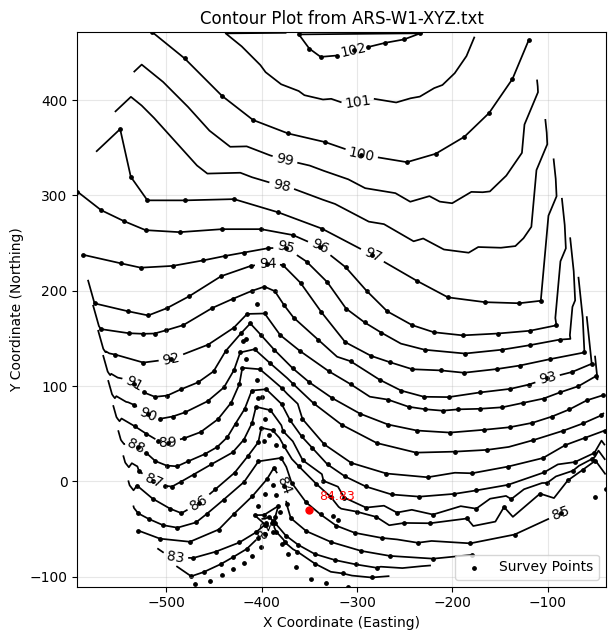

(<matplotlib.tri._triangulation.Triangulation at 0x765468d02bc0>,
 <Axes: title={'center': 'Contour Plot from ARS-W1-XYZ.txt'}, xlabel='X Coordinate (Easting)', ylabel='Y Coordinate (Northing)'>)

In [6]:
plot_contours_triangulated_from_xyz(
    'ARS-W1-XYZ.txt',
    levels=[float(i) for i in range(81,103,1)],
    query_points=[(400, 200), (-350, -30)],  # try one outside the hull too
    on_outside='nearest',   # or 'nan'
    show_points=True
)

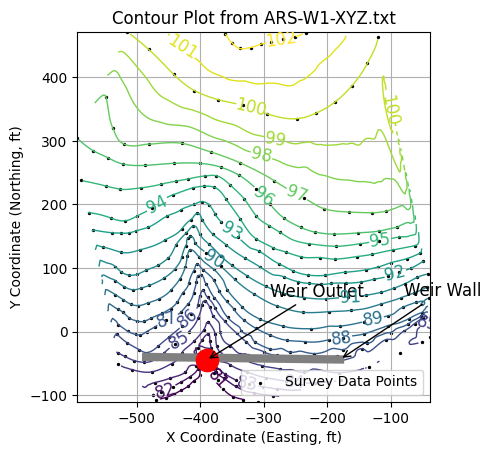

In [7]:
import pandas
import numpy
import matplotlib.pyplot
from scipy.interpolate import griddata
#######################################################################
# Irregular data are interpolated onto a regular grid before plotting #
#######################################################################
# === Load Data ===
filename = 'ARS-W1-XYZ.txt'
my_xyz = pandas.read_csv(filename, sep='\t')
my_xyz = pandas.DataFrame(my_xyz)

coord_x = my_xyz['X-Easting'].values.tolist()
coord_y = my_xyz['Y-Northing'].values.tolist()
coord_z = my_xyz['Z-Elevation'].values.tolist()
coord_xy = numpy.column_stack((coord_x, coord_y))

# === Create Grid ===
lon = numpy.linspace(min(coord_x), max(coord_x), 200)
lat = numpy.linspace(min(coord_y), max(coord_y), 200)
X, Y = numpy.meshgrid(lon, lat)
Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic', fill_value=numpy.nan)

# === Plotting ===
use_basemap = False  # <- Flip to True if you ever want to bring it back

if use_basemap:
    matplotlib.pyplot.rcParams["figure.figsize"] = [10.0, 10.0]
    matplotlib.pyplot.rcParams["figure.autolayout"] = True
    im = matplotlib.pyplot.imread("SomewhereUSABaseMap.png")

fig, ax = matplotlib.pyplot.subplots()

if use_basemap:
    ax.imshow(im, extent=[0, 3361, 0, 1458])

# Contours
levels = [float(i) for i in range(81,103,1)]
CS = ax.contour(X, Y, Z, levels, linewidths=1)
ax.clabel(CS, inline=2, fontsize=12)

# Titles and limits
ax.set_title(f'Contour Plot from {filename}')
ax.set_xlim([min(coord_x), max(coord_x)])
ax.set_ylim([min(coord_y), max(coord_y)])
ax.set_aspect('equal', adjustable='box')  # <- Enforce 1:1 aspect ratio

# Plot a line segment to represent the weir wall
# Line segment coordinates
x1, y1 = -485, -40
x2, y2 = -180, -44

# Draw the line segment
ax.plot([x1, x2], [y1, y2], color='grey', linewidth=6)

# Annotate the segment
ax.annotate("Weir Wall",             # Text label
            xy=(x2, y2),   # Point being annotated
            xytext=(x2 + 100, y2 + 100),  # Label position
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=12, color='black')

# Plot a red filled circle at the gage location
x_marker = -390
y_marker = -45
ax.plot(x_marker, y_marker, 'o', markersize=16, color='red')

# Annotate the marker
ax.annotate("Weir Outlet",             # Text label
            xy=(x_marker, y_marker),   # Point being annotated
            xytext=(x_marker + 100, y_marker + 100),  # Label position
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=12, color='black')

ax.set_xlabel("X Coordinate (Easting, ft)")
ax.set_ylabel("Y Coordinate (Northing, ft)")

ax.grid(True)

# Add scatter plot of original XYZ data
ax.scatter(coord_x, coord_y, color='black', s=2, label='Survey Data Points')
ax.legend(loc='lower right')

matplotlib.pyplot.show()

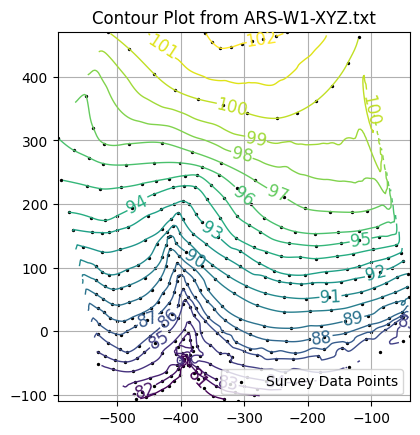

In [8]:
import pandas
import numpy
import matplotlib.pyplot
from scipy.interpolate import griddata
#######################################################################
# Irregular data are interpolated onto a regular grid before plotting #
#######################################################################
original_points=True # switch to overlay original points

# === Load Data ===
filename = 'ARS-W1-XYZ.txt'
my_xyz = pandas.read_csv(filename, sep='\t')
my_xyz = pandas.DataFrame(my_xyz)

coord_x = my_xyz['X-Easting'].values.tolist()
coord_y = my_xyz['Y-Northing'].values.tolist()
coord_z = my_xyz['Z-Elevation'].values.tolist()
coord_xy = numpy.column_stack((coord_x, coord_y))

# === Create Grid ===
lon = numpy.linspace(min(coord_x), max(coord_x), 200)
lat = numpy.linspace(min(coord_y), max(coord_y), 200)
X, Y = numpy.meshgrid(lon, lat)
Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic', fill_value=numpy.nan)

# === Plotting ===
use_basemap = False  # <- Flip to True if you ever want to bring it back

if use_basemap:
    matplotlib.pyplot.rcParams["figure.figsize"] = [10.0, 10.0]
    matplotlib.pyplot.rcParams["figure.autolayout"] = True
    im = matplotlib.pyplot.imread("SomewhereUSABaseMap.png")

fig, ax = matplotlib.pyplot.subplots()

if use_basemap:
    ax.imshow(im, extent=[0, 3361, 0, 1458])

# Contours
levels = [float(i) for i in range(81,103,1)]
CS = ax.contour(X, Y, Z, levels, linewidths=1)
ax.clabel(CS, inline=2, fontsize=12)

# Titles and limits
ax.set_title(f'Contour Plot from {filename}')
ax.set_xlim([min(coord_x), max(coord_x)])
ax.set_ylim([min(coord_y), max(coord_y)])
ax.set_aspect('equal', adjustable='box')  # <- Enforce 1:1 aspect ratio

ax.grid(True)



if original_points:
# Add scatter plot of original XYZ data
    ax.scatter(coord_x, coord_y, color='black', s=2, label='Survey Data Points')
    ax.legend(loc='lower right')

matplotlib.pyplot.show()

Interpolated Z at (400.00, 200.00) = nan


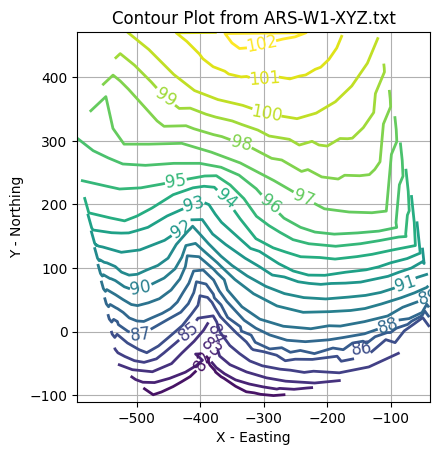

471.053705


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.tri import LinearTriInterpolator

original_points = False # switch to overlay original points
interpolate_flag = True

filename='ARS-W1-XYZ.txt'
# === Load Data ===
my_xyz = pd.read_csv(filename, sep='\t')
coord_x = my_xyz['X-Easting'].values
coord_y = my_xyz['Y-Northing'].values
coord_z = my_xyz['Z-Elevation'].values

# === Triangulate for Irregular Grid ===
triang = tri.Triangulation(coord_x, coord_y)

# === Optional Base Map Image ===
# insert code later


# === Contour Plot via Triangulation ===
fig, ax = plt.subplots()
levels = [float(i) for i in range(81,103,1)]
CS = ax.tricontour(triang, coord_z, levels, linewidths=2)
ax.clabel(CS, inline=True, fontsize=12)

# === Bounding Box Overlay ===
# insert code later

# === Interpolator Block (for future particle tracking logic) ===

if interpolate_flag:
    interpolator = LinearTriInterpolator(triang, coord_z)

    # Define a test point
    x_query = 400
    y_query = 200
    z_est = interpolator(x_query, y_query)
    print(f"Interpolated Z at ({x_query:.2f}, {y_query:.2f}) = {z_est:.3f}")

    ax.plot(x_query, y_query, 'ro')  # Red dot
    ax.annotate(f"{z_est:.2f}", (x_query + 10, y_query + 10), color='red', fontsize=10)

# === Final Plot Settings ===

if original_points:
# Add scatter plot of original XYZ data
    ax.scatter(coord_x, coord_y, color='black', s=2, label='Survey Data Points')
    ax.legend(loc='lower right')
    
ax.set_title(f'Contour Plot from {filename}')
ax.set_xlim([min(coord_x), max(coord_x)])
ax.set_ylim([min(coord_y), max(coord_y)])
ax.set_aspect('equal', adjustable='box')  # <- Enforce 1:1 aspect ratio
ax.set_xlabel("X - Easting")
ax.set_ylabel("Y - Northing")
plt.grid(True)
plt.show()

print(max(coord_y))
CS

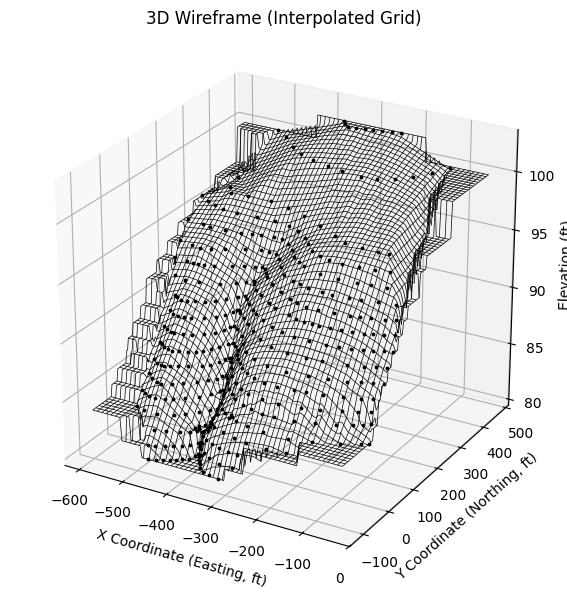

In [10]:
# =====================================================================
# Script: plot_wireframe_from_xyz.py
# Author(s): Sensei + OpenAI
# Date: 2025-08-12
# Description:
#   Utility function to plot a 3D wireframe from an XYZ dataset using
#   gridding + interpolation. Designed for pedagogical use in 
#   JupyterBooks, teaching site characterization, contouring, and 
#   surface visualization. Supports vertical exaggeration to improve
#   interpretability when XY ranges greatly exceed Z range.
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_wireframe_from_xyz(
    filename,
    sep='\t',
    nx=120, ny=120,
    method='linear',          # griddata method: 'linear'|'cubic'|'nearest'
    fill='nearest',           # how to fill NaNs after primary interp: None|'nearest'
    rstride=3, cstride=3,
    linewidth=0.5, edgecolor='k',
    vertical_exag=20.0,       # << user control for vertical exaggeration
    view_elev=25, view_azim=-60,
    show_points=False,        # overlay original points for QA
    point_size=3, point_color='k',
    title='3D Wireframe (Interpolated Grid)',
    ax=None                   # optionally pass an existing 3D axes
):
    """
    Plot a 3D wireframe from an XYZ text file using gridding + interpolation.

    Returns
    -------
    Xg, Yg, Zg, ax : ndarrays and the Matplotlib 3D axes
    """
    # --- Load ---
    df = pd.read_csv(filename, sep=sep)
    x = df['X-Easting'].to_numpy()
    y = df['Y-Northing'].to_numpy()
    z = df['Z-Elevation'].to_numpy()
    xy = np.column_stack([x, y])

    # --- Grid ---
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    Xg, Yg = np.meshgrid(xi, yi)

    # --- Interpolate primary ---
    Zg = griddata(xy, z, (Xg, Yg), method=method)

    # --- Optional fill of holes (edges/convex hull gaps) ---
    if fill == 'nearest':
        mask = np.isnan(Zg)
        if mask.any():
            Zg[mask] = griddata(xy, z, (Xg, Yg), method='nearest')[mask]

    # --- Plot ---
    created_fig = False
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        created_fig = True

    ax.plot_wireframe(Xg, Yg, Zg, rstride=rstride, cstride=cstride,
                      linewidth=linewidth, color=edgecolor)

    if show_points:
        ax.scatter(x, y, z, s=point_size, c=point_color, depthshade=False)

    ax.set_title(title)
    ax.set_xlabel("X Coordinate (Easting, ft)")
    ax.set_ylabel("Y Coordinate (Northing, ft)")
    ax.set_zlabel("Elevation (ft)")

    # Aspect with vertical exaggeration
    ax.set_box_aspect((np.ptp(x), np.ptp(y), (z.max() - z.min()) * vertical_exag))

    # Camera
    ax.view_init(elev=view_elev, azim=view_azim)

    if created_fig:
        plt.tight_layout()
        plt.show()

    return Xg, Yg, Zg, ax

## Usage example
Xg, Yg, Zg, ax = plot_wireframe_from_xyz(
    'ARS-W1-XYZ.txt',
    vertical_exag=25,      # try 10–40 depending on your XY span
    nx=160, ny=160,        # bump resolution if you want smoother wires
    method='linear',       # 'linear' is robust; 'cubic' is prettier but pickier
    show_points=True       # overlay raw XYZ to sanity-check interpolation
)


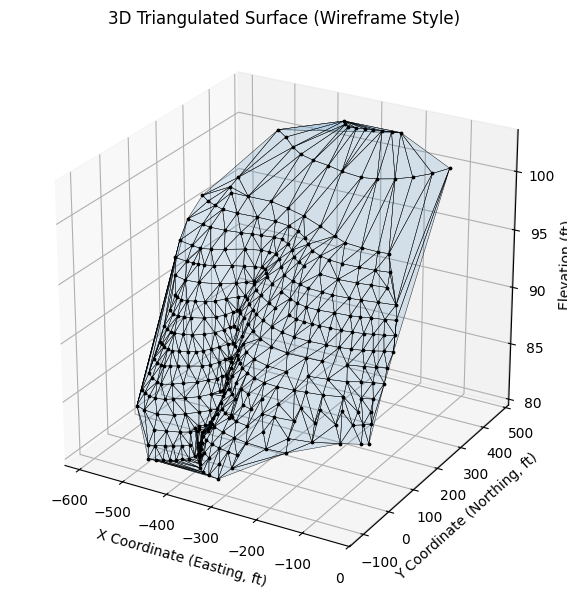

In [11]:
# =====================================================================
# Script: plot_triangulated_surface_from_xyz.py
# Author(s): Sensei + OpenAI
# Date: 2025-08-12
# Description:
#   Utility function to plot a 3D triangulated surface from an XYZ 
#   dataset using Delaunay triangulation of the scattered points. 
#   Designed for pedagogical use in JupyterBooks, teaching site 
#   characterization and surface visualization. Supports vertical 
#   exaggeration to improve interpretability when XY ranges greatly 
#   exceed Z range.
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_triangulated_surface_from_xyz(
    filename,
    sep='\t',
    nx=None, ny=None,          # kept for signature compatibility; not used
    method=None,               # kept for compatibility
    fill=None,                  # kept for compatibility
    rstride=None, cstride=None, # not used in triangulated plotting
    linewidth=0.3, edgecolor='k',
    vertical_exag=20.0,         # user control for vertical exaggeration
    view_elev=25, view_azim=-60,
    show_points=False,          # overlay original points
    point_size=3, point_color='k',
    title='3D Triangulated Surface (Wireframe Style)',
    ax=None                     # optionally pass an existing 3D axes
):
    """
    Plot a 3D triangulated surface from an XYZ text file.

    Parameters
    ----------
    filename : str
        Path to the XYZ text file. Must contain 'X-Easting', 'Y-Northing',
        and 'Z-Elevation' columns.
    sep : str, optional
        Column delimiter (default: tab '\t').
    nx, ny : int, optional
        Unused, present for compatibility with gridded wireframe function.
    method : ignored
        Present for compatibility.
    fill : ignored
        Present for compatibility.
    rstride, cstride : ignored
        Present for compatibility.
    linewidth : float, optional
        Edge line thickness for triangulated surface.
    edgecolor : str, optional
        Edge color for triangulated surface.
    vertical_exag : float, optional
        Vertical exaggeration factor for aspect ratio.
    view_elev, view_azim : float, optional
        Elevation and azimuth angles for the 3D view.
    show_points : bool, optional
        If True, plot original XYZ points.
    point_size : float, optional
        Size of original points if plotted.
    point_color : str, optional
        Color of original points if plotted.
    title : str, optional
        Plot title.
    ax : matplotlib 3D axes, optional
        Pass an existing Axes3D to plot into.

    Returns
    -------
    tri, ax : matplotlib.tri.Triangulation, Axes3D
        Triangulation object and axes object.

    Provenance
    ----------
    Script by Sensei + OpenAI (2025-08-12)
    Developed for JupyterBook lesson on site characterization and
    surface visualization (XYZ → contour, wireframe, and surface plots).
    """
    # --- Load ---
    df = pd.read_csv(filename, sep=sep)
    x = df['X-Easting'].to_numpy()
    y = df['Y-Northing'].to_numpy()
    z = df['Z-Elevation'].to_numpy()

    # --- Triangulation ---
    tri = mtri.Triangulation(x, y)

    # --- Plot ---
    created_fig = False
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        created_fig = True

    # Plot as a thin-edged surface, light face shading
    surf = ax.plot_trisurf(tri, z, linewidth=linewidth, edgecolor=edgecolor,
                           antialiased=True, shade=False, alpha=0.15)

    if show_points:
        ax.scatter(x, y, z, s=point_size, c=point_color, depthshade=False)

    ax.set_title(title)
    ax.set_xlabel("X Coordinate (Easting, ft)")
    ax.set_ylabel("Y Coordinate (Northing, ft)")
    ax.set_zlabel("Elevation (ft)")

    # Aspect with vertical exaggeration
    ax.set_box_aspect((np.ptp(x), np.ptp(y), (z.max() - z.min()) * vertical_exag))

    # Camera
    ax.view_init(elev=view_elev, azim=view_azim)

    if created_fig:
        plt.tight_layout()
        plt.show()

    return tri, ax

tri, ax = plot_triangulated_surface_from_xyz('ARS-W1-XYZ.txt', vertical_exag=25, show_points=True)

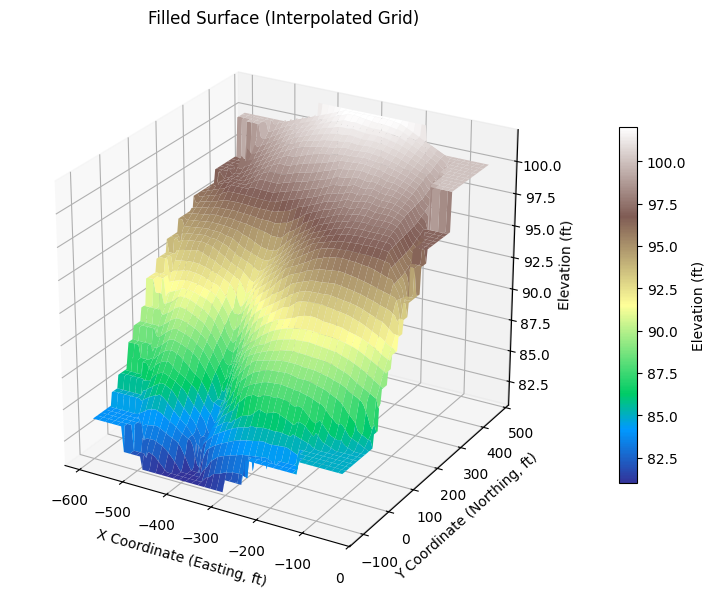

In [12]:
# =====================================================================
# Script: plot_wireframe_from_xyz.py  (now supports filled surfaces)
# Author(s): Sensei + OpenAI
# Date: 2025-08-12
# Description:
#   Plot a 3D wireframe OR a filled, colored surface from an XYZ file.
#   Uses gridding + interpolation; supports vertical exaggeration.
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_wireframe_from_xyz(
    filename,
    sep='\t',
    nx=120, ny=120,
    method='linear',          # 'linear'|'cubic'|'nearest'
    fill='nearest',           # None|'nearest'
    rstride=3, cstride=3,
    linewidth=0.5, edgecolor='k',
    vertical_exag=20.0,
    view_elev=25, view_azim=-60,
    show_points=False, point_size=3, point_color='k',
    title='3D Wireframe (Interpolated Grid)',
    ax=None,
    # --- new args for filled surface ---
    filled=False,             # << set True to color by Z
    cmap='terrain',
    vmin=None, vmax=None,
    alpha=1.0,
    add_colorbar=True
):
    """
    Plot a 3D wireframe (default) or filled colored surface (filled=True)
    from an XYZ text file using gridding + interpolation.

    Provenance
    ----------
    Script by Sensei + OpenAI (2025-08-12)
    """
    # --- Load ---
    df = pd.read_csv(filename, sep=sep)
    x = df['X-Easting'].to_numpy()
    y = df['Y-Northing'].to_numpy()
    z = df['Z-Elevation'].to_numpy()
    xy = np.column_stack([x, y])

    # --- Grid ---
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    Xg, Yg = np.meshgrid(xi, yi)

    # --- Interpolate ---
    Zg = griddata(xy, z, (Xg, Yg), method=method)
    if fill == 'nearest':
        mask = np.isnan(Zg)
        if mask.any():
            Zg[mask] = griddata(xy, z, (Xg, Yg), method='nearest')[mask]

    # --- Plot ---
    created_fig = False
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        created_fig = True
    else:
        # try to find a parent fig (for colorbar)
        fig = ax.get_figure()

    mappable = None
    if filled:
        mappable = ax.plot_surface(
            Xg, Yg, Zg,
            cmap=cmap, vmin=vmin, vmax=vmax,
            linewidth=0, antialiased=True, shade=True, alpha=alpha
        )
    else:
        ax.plot_wireframe(
            Xg, Yg, Zg,
            rstride=rstride, cstride=cstride,
            linewidth=linewidth, color=edgecolor
        )

    if show_points:
        ax.scatter(x, y, z, s=point_size, c=point_color, depthshade=False)

    ax.set_title(title if not filled else title.replace('Wireframe', 'Filled Surface'))
    ax.set_xlabel("X Coordinate (Easting, ft)")
    ax.set_ylabel("Y Coordinate (Northing, ft)")
    ax.set_zlabel("Elevation (ft)")

    ax.set_box_aspect((np.ptp(x), np.ptp(y), (z.max() - z.min()) * vertical_exag))
    ax.view_init(elev=view_elev, azim=view_azim)

    if filled and add_colorbar and created_fig:
        cb = fig.colorbar(mappable, ax=ax, shrink=0.65, pad=0.08)
        cb.set_label("Elevation (ft)")

    if created_fig:
        plt.tight_layout()
        plt.show()

    return Xg, Yg, Zg, ax


# Gridded, filled surface
Xg, Yg, Zg, ax = plot_wireframe_from_xyz(
    'ARS-W1-XYZ.txt',
    filled=True, cmap='terrain', vertical_exag=25,
    title='Filled Surface (Interpolated Grid)'
)

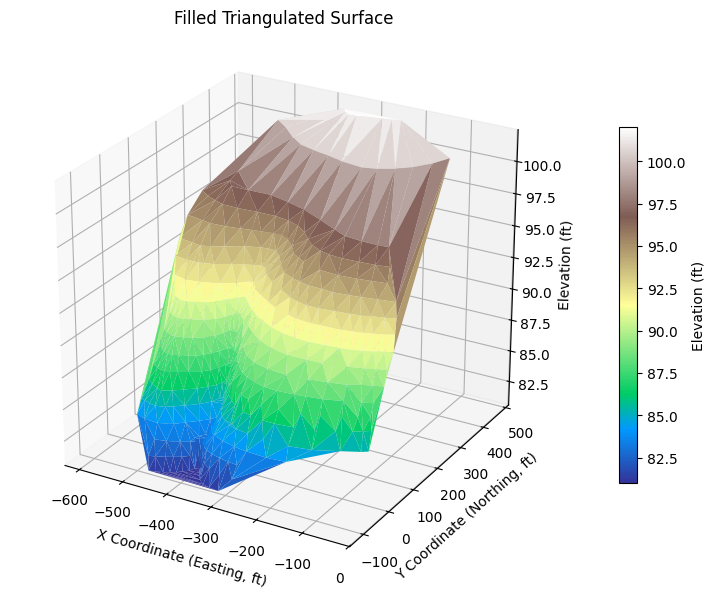

In [13]:
# =====================================================================
# Script: plot_triangulated_surface_from_xyz.py (now supports filled)
# Author(s): Sensei + OpenAI
# Date: 2025-08-12
# Description:
#   Plot a 3D triangulated surface as wire-like edges OR filled, 
#   colored by Z directly from scattered points (no gridding).
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_triangulated_surface_from_xyz(
    filename,
    sep='\t',
    nx=None, ny=None,          # unused; kept for signature parity
    method=None, fill=None,
    rstride=None, cstride=None,
    linewidth=0.3, edgecolor='k',
    vertical_exag=20.0,
    view_elev=25, view_azim=-60,
    show_points=False, point_size=3, point_color='k',
    title='3D Triangulated Surface (Wireframe Style)',
    ax=None,
    # --- new args for filled surface ---
    filled=False,             # << set True to color by Z
    cmap='terrain',
    vmin=None, vmax=None,
    alpha=1.0,
    add_colorbar=True
):
    """
    Plot a 3D triangulated surface from an XYZ text file.

    Provenance
    ----------
    Script by Sensei + OpenAI (2025-08-12)
    """
    # --- Load ---
    df = pd.read_csv(filename, sep=sep)
    x = df['X-Easting'].to_numpy()
    y = df['Y-Northing'].to_numpy()
    z = df['Z-Elevation'].to_numpy()

    tri = mtri.Triangulation(x, y)

    # --- Plot ---
    created_fig = False
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        created_fig = True
    else:
        fig = ax.get_figure()

    mappable = None
    if filled:
        # Filled colored surface
        mappable = ax.plot_trisurf(
            tri, z,
            cmap=cmap, vmin=vmin, vmax=vmax,
            linewidth=0, edgecolor='none', shade=True, alpha=alpha
        )
    else:
        # Wire-like surface (thin edges, translucent faces)
        ax.plot_trisurf(
            tri, z,
            linewidth=linewidth, edgecolor=edgecolor,
            antialiased=True, shade=False, alpha=0.15
        )

    if show_points:
        ax.scatter(x, y, z, s=point_size, c=point_color, depthshade=False)

    ax.set_title(title if not filled else title.replace('Wireframe Style', 'Filled Surface'))
    ax.set_xlabel("X Coordinate (Easting, ft)")
    ax.set_ylabel("Y Coordinate (Northing, ft)")
    ax.set_zlabel("Elevation (ft)")

    ax.set_box_aspect((np.ptp(x), np.ptp(y), (z.max() - z.min()) * vertical_exag))
    ax.view_init(elev=view_elev, azim=view_azim)

    if filled and add_colorbar and created_fig:
        cb = fig.colorbar(mappable, ax=ax, shrink=0.65, pad=0.08)
        cb.set_label("Elevation (ft)")

    if created_fig:
        plt.tight_layout()
        plt.show()

    return tri, ax

# Triangulated, filled surface
tri, ax = plot_triangulated_surface_from_xyz(
    'ARS-W1-XYZ.txt',
    filled=True, cmap='terrain', vertical_exag=25,
    title='Filled Triangulated Surface'
)

In [14]:
%reset -f
# =====================================================================
# Script: plot_wireframe_from_xyz.py  (now with plan-view contour base)
# Author(s): Sensei + OpenAI
# Date: 2025-08-12
# Description:
#   Plot a 3D wireframe OR a filled, colored surface from an XYZ file.
#   Adds an optional plan-view filled contour projected onto a base Z.
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_wireframe_from_xyz(
    filename,
    sep='\t',
    nx=120, ny=120,
    method='linear',
    fill='nearest',
    rstride=3, cstride=3,
    linewidth=0.5, edgecolor='k',
    vertical_exag=20.0,
    view_elev=25, view_azim=-60,
    show_points=False, point_size=3, point_color='k',
    title='3D Wireframe (Interpolated Grid)',
    ax=None,
    # Filled surface options
    filled=False, cmap='terrain', vmin=None, vmax=None, alpha=1.0, add_colorbar=True,
    # NEW: plan-view base contour options
    base_projection=True,            # << enable/disable base “shadow”
    base_z='min',                    # 'min' | 'max' | float (e.g., 0.0)
    base_levels=20,                  # int or list of levels
    base_cmap=None,                  # defaults to cmap if None
    base_alpha=0.9                   # transparency for base
):
    """
    Plot a 3D wireframe (default) or filled colored surface (filled=True)
    with optional plan-view filled contour projected to a base plane.

    Provenance
    ----------
    Script by Sensei + OpenAI (2025-08-12)
    """
    # --- Load ---
    df = pd.read_csv(filename, sep=sep)
    x = df['X-Easting'].to_numpy()
    y = df['Y-Northing'].to_numpy()
    z = df['Z-Elevation'].to_numpy()
    xy = np.column_stack([x, y])

    # --- Grid ---
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    Xg, Yg = np.meshgrid(xi, yi)

    # --- Interpolate ---
    Zg = griddata(xy, z, (Xg, Yg), method=method)
    if fill == 'nearest':
        mask = np.isnan(Zg)
        if mask.any():
            Zg[mask] = griddata(xy, z, (Xg, Yg), method='nearest')[mask]

    # --- Plot ---
    created_fig = False
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        created_fig = True
    else:
        fig = ax.get_figure()

    # Plan-view base projection (before surface so it sits “under” visually)
    if base_projection:
        z0 = np.nanmin(z) if base_z == 'min' else (np.nanmax(z) if base_z == 'max' else float(base_z))
        mappable_base = ax.contourf(
            Xg, Yg, Zg,
            zdir='z', offset=z0,
            levels=base_levels,
            cmap=(base_cmap or cmap),
            vmin=vmin, vmax=vmax, alpha=base_alpha
        )

    mappable = None
    if filled:
        mappable = ax.plot_surface(
            Xg, Yg, Zg,
            cmap=cmap, vmin=vmin, vmax=vmax,
            linewidth=0, antialiased=True, shade=True, alpha=alpha
        )
    else:
        ax.plot_wireframe(
            Xg, Yg, Zg,
            rstride=rstride, cstride=cstride,
            linewidth=linewidth, color=edgecolor
        )

    if show_points:
        ax.scatter(x, y, z, s=point_size, c=point_color, depthshade=False)

    ax.set_title(title if not filled else title.replace('Wireframe', 'Filled Surface'))
    ax.set_xlabel("X Coordinate (Easting, ft)")
    ax.set_ylabel("Y Coordinate (Northing, ft)")
    ax.set_zlabel("Elevation (ft)")

    # Set axis limits to make sure the base plane is visible
    ax.set_xlim(np.min(xi), np.max(xi))
    ax.set_ylim(np.min(yi), np.max(yi))
    if base_projection:
        ax.set_zlim(min(z0, np.nanmin(z)), max(np.nanmax(z), z0))

    # Aspect & camera
    ax.set_box_aspect((np.ptp(x), np.ptp(y), (np.nanmax(z) - np.nanmin(z)) * vertical_exag))
    ax.view_init(elev=view_elev, azim=view_azim)

    if filled and add_colorbar and created_fig:
        fig.colorbar(mappable, ax=ax, shrink=0.65, pad=0.08, label="Elevation (ft)")

    if created_fig:
        plt.tight_layout()
        plt.show()

    return Xg, Yg, Zg, ax

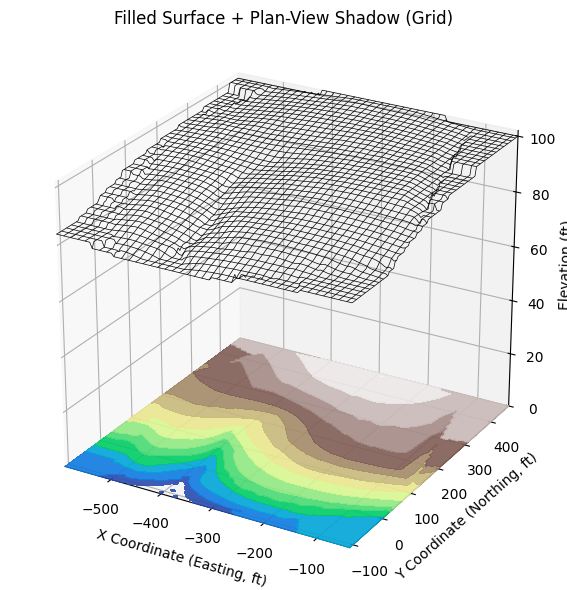

In [15]:
# Gridded, filled + base at Zmin
Xg, Yg, Zg, ax = plot_wireframe_from_xyz(
    'ARS-W1-XYZ.txt',
    filled=False, cmap='terrain', 
    base_projection=True, base_z=0, base_levels=20,
    vertical_exag=25, title='Filled Surface + Plan-View Shadow (Grid)'
)

In [16]:
# =====================================================================
# Script: plot_triangulated_surface_from_xyz.py (with plan-view base)
# Author(s): Sensei + OpenAI
# Date: 2025-08-12
# Description:
#   Plot a 3D triangulated surface; optional plan-view filled contour
#   projected to a base Z for a “shadow” map under the 3D surface.
# =====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_triangulated_surface_from_xyz(
    filename,
    sep='\t',
    nx=None, ny=None, method=None, fill=None,
    rstride=None, cstride=None,
    linewidth=0.3, edgecolor='k',
    vertical_exag=20.0,
    view_elev=25, view_azim=-60,
    show_points=False, point_size=3, point_color='k',
    title='3D Triangulated Surface (Wireframe Style)',
    ax=None,
    # Filled surface options
    filled=False, cmap='terrain', vmin=None, vmax=None, alpha=1.0, add_colorbar=True,
    # NEW: plan-view base contour options
    base_projection=True,
    base_z='min',
    base_levels=20,
    base_cmap=None,
    base_alpha=0.9
):
    """
    Plot a 3D triangulated surface with optional plan-view filled contour.

    Provenance
    ----------
    Script by Sensei + OpenAI (2025-08-12)
    """
    # --- Load ---
    df = pd.read_csv(filename, sep=sep)
    x = df['X-Easting'].to_numpy()
    y = df['Y-Northing'].to_numpy()
    z = df['Z-Elevation'].to_numpy()

    tri = mtri.Triangulation(x, y)

    # --- Plot ---
    created_fig = False
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        created_fig = True
    else:
        fig = ax.get_figure()

    # Plan-view base projection
    if base_projection:
        z0 = np.nanmin(z) if base_z == 'min' else (np.nanmax(z) if base_z == 'max' else float(base_z))
        ax.tricontourf(
            tri, z,
            zdir='z', offset=z0,
            levels=base_levels,
            cmap=(base_cmap or cmap),
            vmin=vmin, vmax=vmax, alpha=base_alpha
        )

    mappable = None
    if filled:
        mappable = ax.plot_trisurf(
            tri, z,
            cmap=cmap, vmin=vmin, vmax=vmax,
            linewidth=0, edgecolor='none', shade=True, alpha=alpha
        )
    else:
        ax.plot_trisurf(
            tri, z,
            linewidth=linewidth, edgecolor=edgecolor,
            antialiased=True, shade=False, alpha=0.15
        )

    if show_points:
        ax.scatter(x, y, z, s=point_size, c=point_color, depthshade=False)

    ax.set_title(title if not filled else title.replace('Wireframe Style', 'Filled Surface'))
    ax.set_xlabel("X Coordinate (Easting, ft)")
    ax.set_ylabel("Y Coordinate (Northing, ft)")
    ax.set_zlabel("Elevation (ft)")

    # Limits so the base plane is visible
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))
    if base_projection:
        ax.set_zlim(min(z0, np.nanmin(z)), max(np.nanmax(z), z0))

    # Aspect & camera
    ax.set_box_aspect((np.ptp(x), np.ptp(y), (np.nanmax(z) - np.nanmin(z)) * vertical_exag))
    ax.view_init(elev=view_elev, azim=view_azim)

    if filled and add_colorbar and created_fig:
        fig.colorbar(mappable, ax=ax, shrink=0.65, pad=0.08, label="Elevation (ft)")

    if created_fig:
        plt.tight_layout()
        plt.show()

    return tri, ax

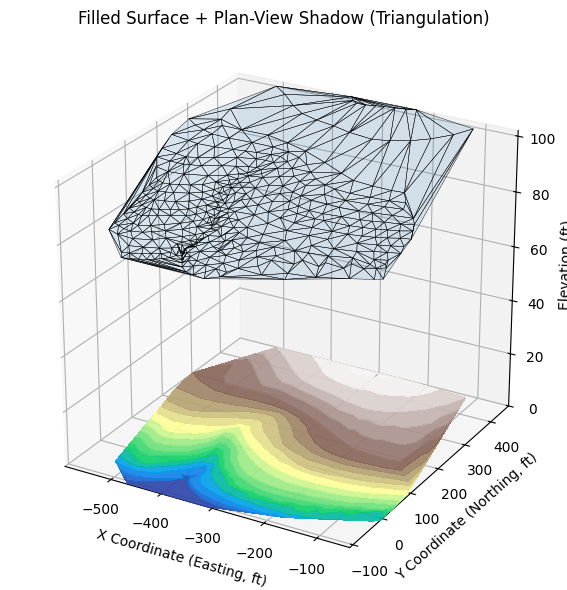

In [17]:
# Triangulated, filled + base at Z=0.0 (constant)
tri,ax = plot_triangulated_surface_from_xyz(
    'ARS-W1-XYZ.txt',
    filled=False, cmap='terrain', 
    base_projection=True, base_z=0.0, base_levels=20,
    vertical_exag=25, title='Filled Surface + Plan-View Shadow (Triangulation)'
)

In [18]:
%reset -f 

2025-08-13 19:07:14.234 (   2.060s) [    7654AA3C41C0]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=


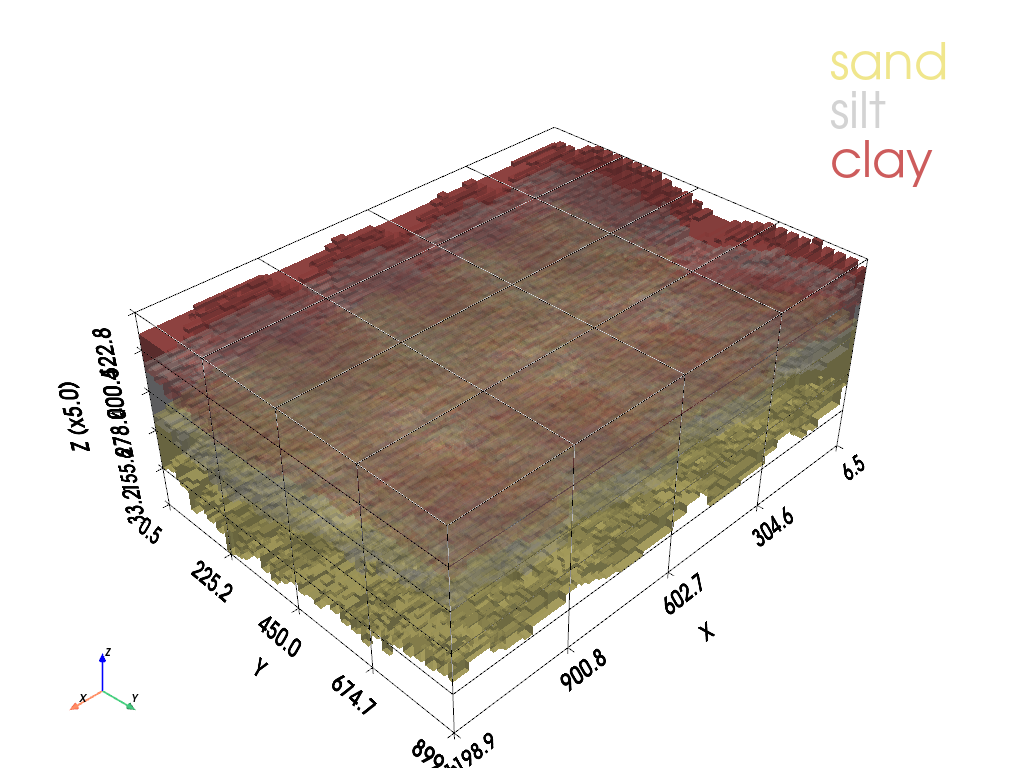

In [19]:
%reset -f 
# ================================================================
# Build categorical facies volume (sand/silt/clay) from irregular
# horizon points, then render as a 3D block model in PyVista.
# Files: toy_surfaces_points.csv (horizon points)
# Author(s): Sensei + OpenAI — 2025-08-12
# ================================================================
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import pyvista as pv

# --- Prototype functions

def exaggerate_image_z(grid, ve=20.0):
    sx, sy, sz = grid.spacing
    grid.spacing = (sx, sy, sz * ve)   # stretch Z in world coordinates
    return grid

# --- Load irregular horizon points ---
surfaces = pd.read_csv("toy_surfaces_points.csv")
x, y = surfaces["x"].to_numpy(), surfaces["y"].to_numpy()
z_top       = surfaces["z_top"].to_numpy()
z_base_clay = surfaces["z_base_clay"].to_numpy()
z_base_silt = surfaces["z_base_silt"].to_numpy()
z_bottom    = surfaces["z_bottom"].to_numpy()

# --- Define target uniform grid in XY and Z ---
nx, ny, nz = 120, 90, 50            # tweak for resolution/performance
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
Xg, Yg = np.meshgrid(xi, yi)

# Interpolate each horizon to the XY grid
pts = np.c_[x, y]
def _interp(surface_vals):
    Zg = griddata(pts, surface_vals, (Xg, Yg), method="linear")
    # fill extrapolation holes at hull edges
    if np.isnan(Zg).any():
        Znn = griddata(pts, surface_vals, (Xg, Yg), method="nearest")
        Zg[np.isnan(Zg)] = Znn[np.isnan(Zg)]
    return Zg

Ztop_g   = _interp(z_top)
Zbc_g    = _interp(z_base_clay)
Zbs_g    = _interp(z_base_silt)
Zbot_g   = _interp(z_bottom)

# Vertical sampling
zmin = float(np.nanmin(Zbot_g))
zmax = float(np.nanmax(Ztop_g))
zk = np.linspace(zmin, zmax, nz)    # elevation levels of voxel centers

# --- Classify facies (0=outside/void, 1=sand, 2=silt, 3=clay) ---
# Broadcast 2D horizons (ny,nx) against Z (1,1,nz)
Z3 = zk.reshape(1,1,-1)
Ztop   = Ztop_g[..., None]
Zbc    = Zbc_g[..., None]
Zbs    = Zbs_g[..., None]
Zbot   = Zbot_g[..., None]

facies = np.zeros((ny, nx, nz), dtype=np.int8)
# clay: between base_clay and top
mask = (Z3 <= Ztop) & (Z3 > Zbc)
facies[mask] = 3
# silt: between base_silt and base_clay
mask = (Z3 <= Zbc) & (Z3 > Zbs)
facies[mask] = 2
# sand: between bottom and base_silt
mask = (Z3 <= Zbs) & (Z3 >= Zbot)
facies[mask] = 1

# --- Build PyVista uniform grid (ImageData) ---
dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)
dz = (zmax - zmin) / (nz - 1)

grid = pv.ImageData()
grid.dimensions = (nx, ny, nz)
grid.origin = (xmin, ymin, zmin)
grid.spacing = (dx, dy, dz)

# VTK expects Fortran order for raveling volumetric scalars
grid["facies"] = facies.ravel(order="F")

# --- Plot ---
p = pv.Plotter()
vertical_stretch = 5.0
exaggerate_image_z(grid, ve=vertical_stretch)

#actor = p.add_mesh(grid.threshold([0.5, 3.5], scalars="facies"),show_scalar_bar=False)
#actor.SetScale(1.0, 1.0, vertical_stretch)   # x, y, z scales

# Show each category with its own color & legend
colors = {1: "khaki", 2: "lightgray", 3: "indianred"}  # sand, silt, clay
labels = {1: "sand", 2: "silt", 3: "clay"}

p.add_legend([[labels[1], colors[1]],
              [labels[2], colors[2]],
              [labels[3], colors[3]]],
             bcolor="white")

for code in (1, 2, 3):
    # Select voxels whose facies is "code" (half-open bin around the code)
    band = grid.threshold([code - 0.5, code + 0.5], scalars="facies")
    if band.n_cells > 0:
        p.add_mesh(band, color=colors[code], opacity=0.85, show_edges=False, name=labels[code])

p.add_axes()
#p.show_bounds(grid="front", location="outer", ticks="outside", xlabel="X", ylabel="Y", zlabel="Z (elev)")
p.show_bounds(grid="front", location="outer", ticks="outside",
              xtitle="X", ytitle="Y", ztitle="Z (x" +repr(vertical_stretch)+")")
# For notebooks: p.show(jupyter_backend='static')
p.show(jupyter_backend='static')


In [20]:
# =====================================================================
# Script: plot_facies_slice.py
# Author(s): Sensei + OpenAI
# Date: 2025-08-12
# Description:
#   Vertical slice through a categorical facies volume (pyvista.ImageData)
#   at a constant X (YZ plane) or constant Y (XZ plane). Supports thin
#   plane or thick slab, vertical exaggeration, and compact legend.
# =====================================================================
import numpy as np
import pyvista as pv

def exaggerate_image_z(grid: pv.ImageData, ve: float = 1.0) -> pv.ImageData:
    """Scale Z spacing of an ImageData grid (in-place)."""
    if ve and ve != 1.0:
        sx, sy, sz = grid.spacing
        grid.spacing = (sx, sy, sz * ve)
    return grid

def plot_facies_slice(
    grid: pv.ImageData,
    axis: str,            # 'x' => YZ slice at X=value; 'y' => XZ slice at Y=value
    value: float,         # the world coordinate along the chosen axis
    *,
    thick: float = 0.0,                 # 0 => exact plane; >0 => slab thickness
    vertical_exag: float = 1.0,         # multiplies Z spacing (dataset-level)
    colors: dict = None,                # {1:'khaki',2:'lightgray',3:'indianred'}
    labels: dict = None,                # {1:'sand',2:'silt',3:'clay'}
    legend_size=(0.12, 0.14),
    legend_loc='upper right',
    show_scalar_bar: bool = False,
    jupyter_backend: str | None = None  # e.g., 'static' or 'trame'
):
    """
    Render a vertical slice through a facies volume at X=value or Y=value.

    Parameters
    ----------
    grid : pv.ImageData
        Uniform grid with integer 'facies' codes (1=sand, 2=silt, 3=clay).
    axis : {'x','y'}
        Which coordinate to hold constant: 'x' -> YZ slice; 'y' -> XZ slice.
    value : float
        World-coordinate position for the slice.
    thick : float, optional
        If > 0, extract a slab of that thickness centered at 'value'.
    vertical_exag : float, optional
        Multiply Z spacing at dataset level (axes/bounds remain honest).
    colors, labels : dict, optional
        Facies color and label maps.
    legend_size : (float,float), optional
        Legend size as fraction of viewport (width, height).
    legend_loc : str, optional
        Legend anchor location.
    show_scalar_bar : bool, optional
        Show scalar bar (usually False for categorical classes).
    jupyter_backend : str or None
        Force a Jupyter backend.

    Returns
    -------
    geom : pyvista.DataSet
        Slice geometry (plane or slab).
    p : pv.Plotter
        Plotter used.
    """
    if jupyter_backend:
        try:
            pv.set_jupyter_backend(jupyter_backend)
        except Exception:
            pass

    if colors is None:
        colors = {1: "khaki", 2: "lightgray", 3: "indianred"}
    if labels is None:
        labels = {1: "sand", 2: "silt", 3: "clay"}

    # Work on a shallow copy; exaggerate Z spacing
    g = grid.copy(deep=False)
    exaggerate_image_z(g, vertical_exag)

    xmin, xmax, ymin, ymax, zmin, zmax = g.bounds

    if axis.lower() == 'x':
        if not (xmin <= value <= xmax):
            raise ValueError(f"X=value ({value}) outside bounds [{xmin}, {xmax}]")
        normal = 'x'
        # Build geometry
        if thick > 0:
            half = 0.5 * thick
            geom = g.clip(normal='-x', origin=(value - half, ymin, zmin))
            geom = geom.clip(normal='+x', origin=(value + half, ymin, zmin))
        else:
            geom = g.slice(normal='x', origin=(value, 0.5*(ymin+ymax), 0.5*(zmin+zmax)))
        view_fn = 'view_yz'
        fixed_title = f"X = {value:g}"
        free1, free2 = "Y", f"Z (×{vertical_exag:g})"

    elif axis.lower() == 'y':
        if not (ymin <= value <= ymax):
            raise ValueError(f"Y=value ({value}) outside bounds [{ymin}, {ymax}]")
        normal = 'y'
        if thick > 0:
            half = 0.5 * thick
            geom = g.clip(normal='-y', origin=(xmin, value - half, zmin))
            geom = geom.clip(normal='+y', origin=(xmin, value + half, zmin))
        else:
            geom = g.slice(normal='y', origin=(0.5*(xmin+xmax), value, 0.5*(zmin+zmax)))
        view_fn = 'view_xz'
        fixed_title = f"Y = {value:g}"
        free1, free2 = "X", f"Z (×{vertical_exag:g})"

    else:
        raise ValueError("axis must be 'x' or 'y'")

    # Plot per-facies to keep categorical colors and add a compact legend
    p = pv.Plotter()
    added = False
    for code in (1, 2, 3):
        part = geom.threshold([code - 0.5, code + 0.5], scalars="facies")
        if part.n_cells > 0:
            p.add_mesh(part, color=colors[code], show_scalar_bar=show_scalar_bar, name=labels[code])
            added = True
    if not added:
        raise RuntimeError("Slice contains no cells with facies 1, 2, or 3 at the chosen location.")

    p.add_legend([[labels[1], colors[1]], [labels[2], colors[2]], [labels[3], colors[3]]],
                 size=legend_size, loc=legend_loc, bcolor="white", border=True)

    # Orient camera perpendicular to the slice; parallel projection → 2D feel
    getattr(p, view_fn)()            # p.view_yz() or p.view_xz()
    p.enable_parallel_projection()

    # Axis titles: show the fixed coordinate and label the varying axes
    p.show_bounds(grid="front", location="outer", ticks="outside",
                  xtitle=fixed_title if axis=='x' else free1,
                  ytitle=free1 if axis=='x' else fixed_title,
                  ztitle=free2)

    p.show()
    return geom, p


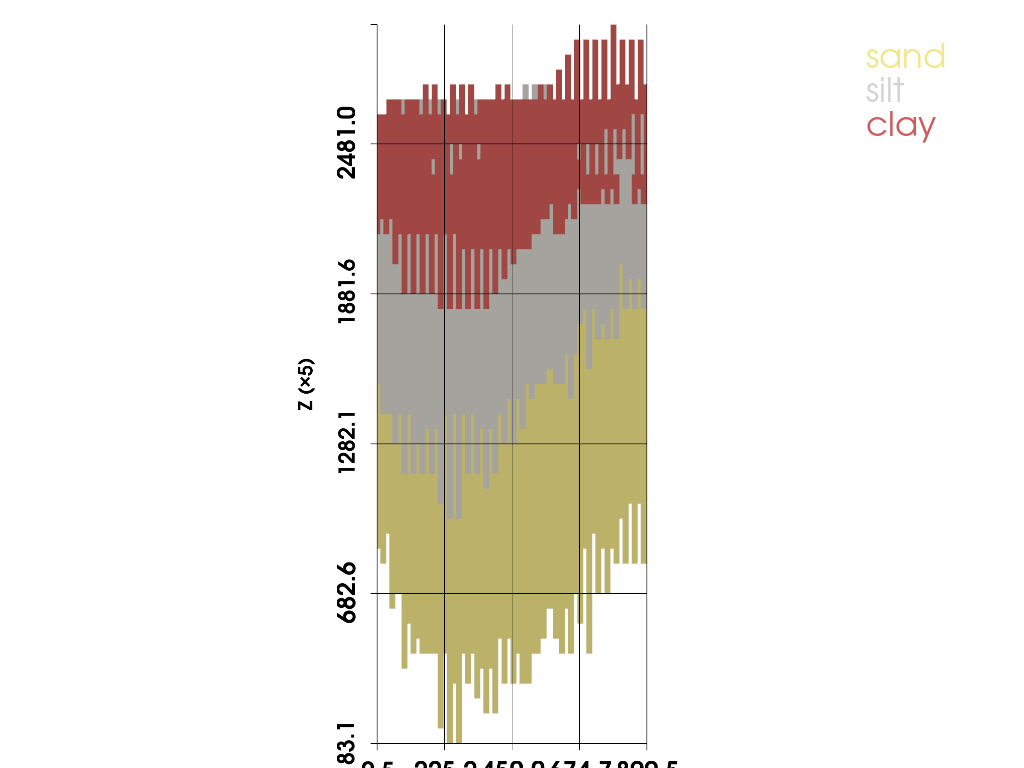

(PolyData (0x765464c43d00)
   N Cells:    4361
   N Points:   4500
   N Strips:   0
   X Bounds:   6.000e+02, 6.000e+02
   Y Bounds:   4.669e-01, 8.995e+02
   Z Bounds:   3.318e+01, 2.481e+03
   N Arrays:   1,
 <pyvista.plotting.plotter.Plotter at 0x7654523f4610>)

In [21]:
# YZ slice at X = 600 (your earlier case)
plot_facies_slice(grid, axis='x', value=600.0, thick=0.0, vertical_exag=5.0, jupyter_backend='static')


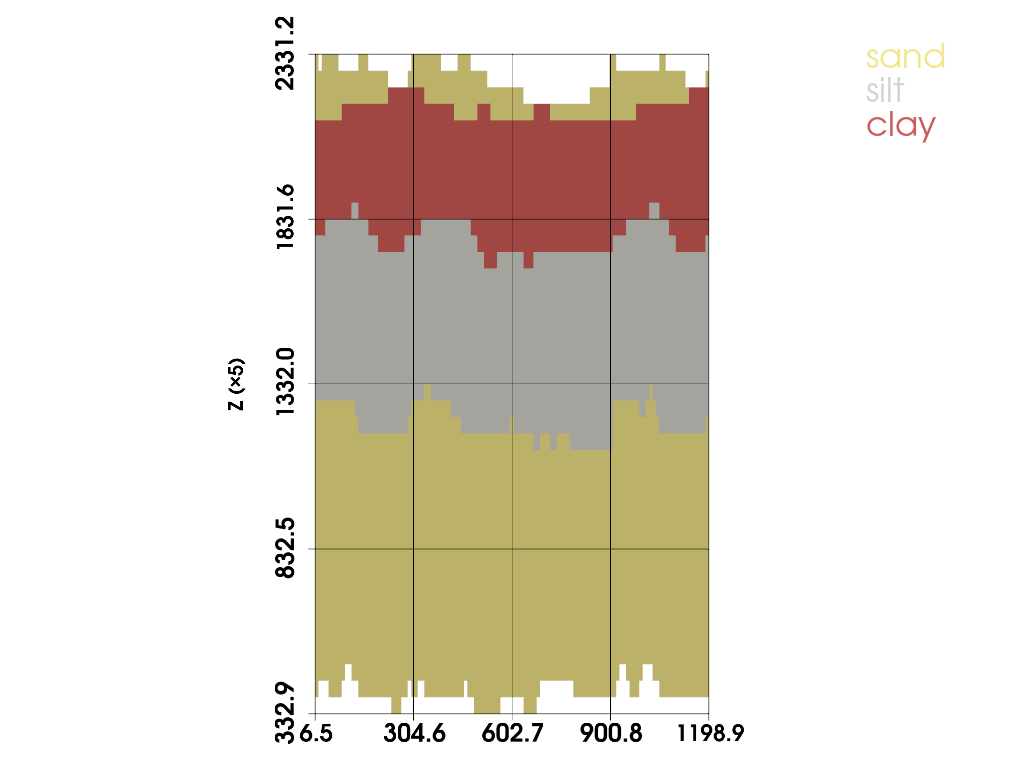

(PolyData (0x765464c42560)
   N Cells:    5831
   N Points:   6000
   N Strips:   0
   X Bounds:   6.516e+00, 1.199e+03
   Y Bounds:   4.500e+02, 4.500e+02
   Z Bounds:   3.318e+01, 2.481e+03
   N Arrays:   1,
 <pyvista.plotting.plotter.Plotter at 0x765468ebf5b0>)

In [22]:
# XZ slice at Y = 450 with a 10-unit slab
plot_facies_slice(grid, axis='y', value=450.0, thick=0.0, vertical_exag=5.0, jupyter_backend='static')